# A convolutional neural network that identifies linear structures in galaxies, called bars

In [40]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import theano
import keras
from scipy.ndimage import imread, zoom
from sklearn import datasets, svm, metrics
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras.models import Sequential
from keras.optimizers import SGD
from keras.utils.np_utils import to_categorical
from keras.models import load_model
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D


def put_together(cat, imsize=75, rescale=1, colorim=False):
    '''stack individual images into a dict'''
    if colorim:
        all_maps= { 'maps': np.zeros( [cat.shape[0], int(np.ceil(imsize*2*rescale)), 
                                       int(np.ceil(imsize*2*rescale)), 3]), 'bar_fraction': np.zeros(cat.shape[0]) } 
    else:
        all_maps= { 'maps': np.zeros( [cat.shape[0], int(np.ceil(imsize*2*rescale)),
                                       int(np.ceil(imsize*2*rescale))]), 'bar_fraction': np.zeros(cat.shape[0]) } 

    for number, index in enumerate(cat.index):

        image = imread( '%s%s.jpg' % (galaxy_zoo_path, int(cat.loc[ index, 'GalaxyID']) ) )
        cen= [image.shape[0]/2 , image.shape[1]/2 ]  
        image_g = image[ cen[0] - imsize : cen[0] + imsize, cen[1] - imsize : cen[1] + imsize, 0]
        image_r = image[ cen[0] - imsize : cen[0] + imsize, cen[1] - imsize : cen[1] + imsize, 1]
        image_i = image[ cen[0] - imsize : cen[0] + imsize, cen[1] - imsize : cen[1] + imsize, 2]
                
        if rescale != 1:
            image_g = zoom(image_g, zoom=rescale) 
            image_r = zoom(image_r, zoom=rescale) 
            image_i = zoom(image_i, zoom=rescale) 

        if colorim:
            all_maps['maps'][number, :, :,0] = image_g
            all_maps['maps'][number, :, :,1] = image_r
            all_maps['maps'][number, :, :,2] = image_i
        else:
            all_maps['maps'][number, :, :] = image_r

        all_maps['bar_fraction'][number] = cat.loc[index, 'Class3.1']
        
    return all_maps


def check_all_data (all_data , galaxyid, imsize=75, colorim=False):
    '''check that my compiled maps look right compared to original'''

    if colorim:
        input_maps = all_data['maps'].astype('uint8')
    else:
        input_maps= all_data['maps']
    
    for index in np.random.permutation(xrange(all_data['maps'].shape[0])) : 

        plt.ion()
        plt.clf()
        plt.subplot(121)
        plt.imshow( input_maps[index], aspect='equal')
        plt.title('Compiled map')
        #        plt.title('P_bar: %0.2f' % all_data['bar_fraction'][index] )
        plt.figtext(.1, .92, 'GalaxyID: %r' % galaxyid[index], size='large')
       
        try:
            under_score = galaxyid[index].find('_')
        except:
            file_name=int(galaxyid[index])
        else:
            file_name=int(str(galaxyid[index])[:under_score])
                        
            
        image = imread ( '%s%s.jpg' % (galaxy_zoo_path, file_name ))
        cen= [image.shape[0]/2 , image.shape[1]/2 ]

        if colorim:            
            image_trim = image[ cen[0] - imsize : cen[0] + imsize, cen[1] - imsize : cen[1] + imsize]
        else:
            image_trim = image[ cen[0] - imsize : cen[0] + imsize, cen[1] - imsize : cen[1] + imsize, 1]
            
        plt.subplot(122)
        plt.imshow(image_trim, aspect='equal')
        plt.title('Original map')
        plt.draw()
        plt.show()
                      
        waitplot= raw_input('Another? (n to exit): ')
        if waitplot == 'n':
            break
        else: continue

            

In [ ]:
# path to the images
galaxy_zoo_path='/Users/edmondcheung/Documents/Python/galaxy_zoo_kaggle/images_training_rev1/'
tsol = pd.read_csv( 'training_solutions_rev1.csv', sep=',', header=0, index_col=False)

# selecting only disk galaxies based on classification thresholds from Willet et al. 2013
# (http://ads.nao.ac.jp/abs/2013MNRAS.435.2835W)
disks= tsol[ (tsol['Class1.2'] >= 0.430) & (tsol['Class2.2'] >= 0.715) ] 

# separate into definitely barred and definitely not
# these thresholds are based on Figure 10 of Willett et al. 2013
def_bar = disks[ disks['Class3.1'] >= 0.7]
def_not = disks[ disks['Class3.1'] <= 0.05]


# collect all maps into one array and flatten
# I've cropped and rescaled the images to reduce the # of dimensions
# I've also just considered the one band instead of all three bands
# based on numerous tests, these transformations do not negatively affect the accuracy
all_bars=put_together(def_bar, imsize=75, rescale=0.5, colorim=False)
all_not=put_together(def_not, imsize=75, rescale=0.5, colorim=False)

## If you want to take a look at the barred galaxies, uncomment below

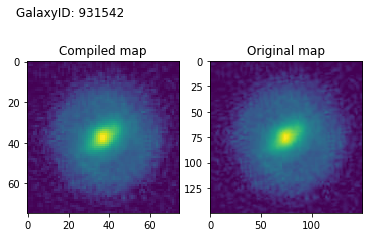

Another? (n to exit): 


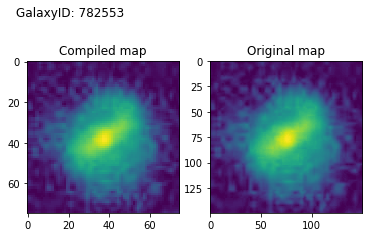

Another? (n to exit): 


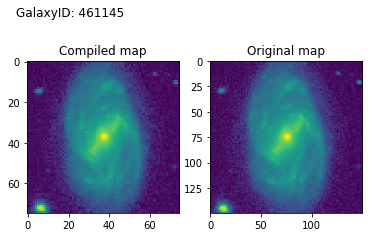

Another? (n to exit): n


In [43]:
check_all_data(all_bars, galaxyid = def_bar['GalaxyID'].values)

## If you want to take a look at the barred galaxies, uncomment below

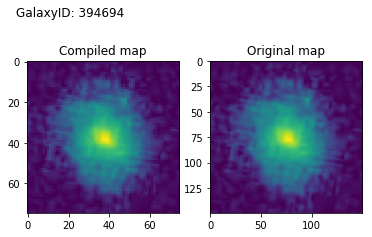

Another? (n to exit): 


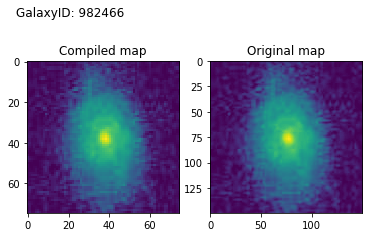

Another? (n to exit): 


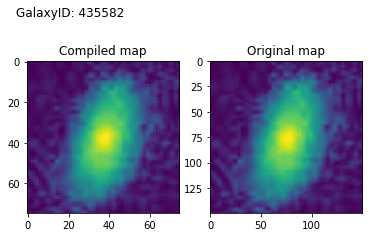

Another? (n to exit): n


In [42]:
check_all_data(all_not, galaxyid = def_not['GalaxyID'].values)

## Concatenate bars and unbarred galaxies into one array and one dataframe

In [19]:
X_bar = all_bars['maps']
X_not = all_not['maps']
y_bar = np.ones(X_bar.shape[0])
y_not = np.zeros(X_not.shape[0])

X_org= np.concatenate( (X_bar, X_not) )
y_org = np.concatenate( (y_bar, y_not) )
df_org = pd.concat( [def_bar, def_not] , keys=['bar', 'not'] ) 

X_org.shape, y_org.shape
#df_org.info()

((3854, 75, 75), (3854,))

## Normalize data and split into training and testing sets

In [6]:
# convert data type and normalize
X_org_scaled =(X_org - X_org.mean( axis=(1,2), keepdims=True)) / X_org.std( axis=(1,2), keepdims=True)

# Split original data into training and testing sets
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(
    X_org_scaled, y_org, np.arange(y_org.shape[0]), test_size=0.3, stratify = y_org)

df_train = df_org.iloc[train_indices,:]
df_test = df_org.iloc[test_indices, :]

## The convolutional neural network

In [9]:
X_train = X_train.reshape(X_train.shape[0], 75, 75, 1)
X_test = X_test.reshape(X_test.shape[0], 75, 75, 1)

cnn_model = Sequential()
cnn_model.add(Conv2D(32, (3,3), padding='same', input_shape=X_train.shape[1:], data_format='channels_last'))
cnn_model.add(Activation('relu'))
cnn_model.add(Conv2D(32, (3,3)))
cnn_model.add(Activation('relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))
cnn_model.add(Dropout(.25))

cnn_model.add(Conv2D(64, (3,3), padding='same'))
cnn_model.add(Activation('relu'))
cnn_model.add(Conv2D(64, (3,3) ))
cnn_model.add(Activation('relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))
cnn_model.add(Dropout(.25))

cnn_model.add(Conv2D(128, (3,3), padding='same'))
cnn_model.add(Activation('relu'))
cnn_model.add(Conv2D(128, (3,3) ))
cnn_model.add(Activation('relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))
cnn_model.add(Dropout(.25))

cnn_model.add(Flatten())
cnn_model.add(Dense(3000))
cnn_model.add(Activation('sigmoid'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(1))
cnn_model.add(Activation('sigmoid'))

# compile
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
cnn_model.compile( loss='binary_crossentropy', optimizer = opt , metrics=['binary_accuracy'])

#fit
n_epoch=40 
history_cnn=cnn_model.fit( X_train , y_train, epochs=n_epoch, verbose=1, validation_split=0.2)  


# evaluate
cnn_score = cnn_model.evaluate(X_test, y_test, verbose=1)
print 'Evaluation score: %r' % cnn_score

y_train_pred = np.ravel(cnn_model.predict_classes(X_train, verbose=1))
train_acc = np.sum(y_train == y_train_pred, axis=0) / float(X_train.shape[0])
print('Training accuracy: %.2f ' % (train_acc * 100.))

y_test_pred = np.ravel(cnn_model.predict_classes(X_test, verbose=1))
test_acc = np.sum(y_test == y_test_pred, axis=0) / float(X_test.shape[0])
print('Test accuracy: %.2f ' % (test_acc * 100.))

print("Classification report for convolutioanl neural network on test set %r:\n%s\n"
    % (cnn_model.summary(), metrics.classification_report(y_test , y_test_pred)))
print 'ROC AUC score: %.4f' % (metrics.roc_auc_score(y_test, y_test_pred))

Train on 2157 samples, validate on 540 samples
Epoch 1/5
2157/2157 [==============================] - 80s - loss: 0.7204 - binary_accuracy: 0.5818 - val_loss: 0.6346 - val_binary_accuracy: 0.6759

## Plot cost/loss curve

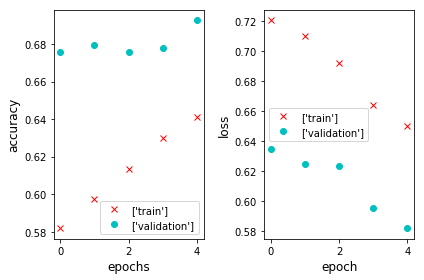

In [10]:
plt.ion()
plt.clf()
plt.subplot(121)
plt.plot( np.arange(len(history_cnn.history['binary_accuracy'])), 
         history_cnn.history['binary_accuracy'], 'rx' , label=['train'])
plt.plot( np.arange(len(history_cnn.history['val_binary_accuracy'])), 
         history_cnn.history['val_binary_accuracy'], 'co' , label=['validation'])
plt.xlabel('epochs', fontsize='large')
plt.ylabel('accuracy', fontsize='large')
plt.legend(fontsize='medium')
plt.tight_layout()

plt.subplot(122)
plt.plot( np.arange(len(history_cnn.history['loss'])), 
         history_cnn.history['loss'], 'rx', label=['train'], )
plt.plot( np.arange(len(history_cnn.history['val_loss'])), 
         history_cnn.history['val_loss'] , 'co', label=['validation'], )
plt.xlabel('epoch', fontsize='large')
plt.ylabel('loss', fontsize='large')
plt.legend( fontsize='medium')
plt.tight_layout()
plt.show()